In [ ]:
import os
import torch
import numpy as np
import random
import json

def seed_torch(seed=7):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True, warn_only=False)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

seed_torch(1)

args = {
    'data_root_dir': '/data1/wsi_datasets', # TODO: enter the root directory containing the extracted 5x and 20x feature folders
    'max_epochs': 50,
    'lr': 1e-4,
    'feature_extractor': 'conch',   # TODO: choose between ['plip', 'quiltnet', 'conch']
    'feature_dim': 512,
    'few_shot_num': 16,            # TODO: choose between [4, 8, 16]
    'high_mag': '20x',
    'low_mag': '5x',
    'label_frac': 1.0,
    'seed': 1,
    'k': 5,
    'k_start': -1,
    'k_end': -1,
    'results_dir': './results',
    'log_data': False,
    'testing': False,
    'early_stopping': False,
    'opt': 'adam',
    'drop_out': False,
    'model_type': 'HiVE_MIL',
    'mode': 'transformer',
    'weighted_sample': False,
    'reg': 1e-5,
    'bag_loss': 'ce',
    'task': 'tcga_brca',           # TODO: choose between ['tcga_brca', 'tcga_nsclc', 'tcga_rcc']
    'text_prompt': None,
    'prototype_number': None,
    'device': 'cuda:0',

    # HiVE_MIL specific arguments
    'LLM': 'gpt4o',
    'num_context_tokens': 16,
    'class_specific_token': False,
    'class_token_position': 'end',
    'num_low_mag_texts': 4,
    'num_high_mag_subtexts': 3,
    'filter_alpha': 0.5,
    'contrastive_lambda': 0.5
}

args['exp_code'] = (
    f"{args['task']}_"
    f"{args['feature_extractor']}_"
    f"{args['model_type']}_"
    f"{args['few_shot_num']}"
)

args['results_dir'] = os.path.join(
    args['results_dir'],
    args['task'],
    args['feature_extractor'],
    str(args['few_shot_num']),
    f"{args['exp_code']}_s{args['seed']}",
)

args['text_prompt'] = os.path.join(
    'text_prompt',
    args['model_type'],
    args['LLM'],
    f"{args['task']}.json"
)

settings = {
    'num_splits': args['k'],
    'k_start': args['k_start'],
    'k_end': args['k_end'],
    'task': args['task'],
    'feature_extractor': args['feature_extractor'],
    'feature_dim': args['feature_dim'],
    'model_type': args['model_type'],
    'few_shot_num': args['few_shot_num'],
    'max_epochs': args['max_epochs'],
    'results_dir': args['results_dir'],
    'lr': args['lr'],
    'experiment': args['exp_code'],
    'label_frac': args['label_frac'],
    'seed': args['seed'],
    'mode': args['mode'],
    'use_drop_out': args['drop_out'],
    'opt': args['opt']
}

for k, v in settings.items():
    print(f"{k}: {v}")
from types import SimpleNamespace

args = SimpleNamespace(**args)


num_splits: 5
k_start: -1
k_end: -1
task: tcga_brca
feature_extractor: conch
feature_dim: 512
model_type: HiVE_MIL
few_shot_num: 16
max_epochs: 50
results_dir: ./results/tcga_brca/conch/16/tcga_brca_conch_HiVE_MIL_16_s1
lr: 0.0001
experiment: tcga_brca_conch_HiVE_MIL_16
label_frac: 1.0
seed: 1
mode: transformer
use_drop_out: False
opt: adam


In [ ]:

from __future__ import print_function
import os
from utils.utils import *
from dataset_model.dataset_generic import Generic_MIL_Dataset
import os

args.split_dir = os.path.join('splits', args.task, args.task+'_{}'.format(int(args.few_shot_num)))

print('\nLoad Dataset')

if args.task == 'tcga_nsclc':
    args.n_classes=2
    dataset = Generic_MIL_Dataset(csv_path = 'dataset_csv/tcga_nsclc.csv',
                                  model_type = args.model_type,
                                  feature_extractor = args.feature_extractor,
                                  data_root = f"{args.data_root_dir}/{args.task}_{args.feature_extractor}",
                                  data_dir_s = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.low_mag))),
                                  data_dir_l = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.high_mag))),
                                  shuffle = False,
                                  print_info = True,
                                  label_dict = {'LUAD':0, 'LUSC':1},
                                  patient_strat= False,
                                  ignore=[])

elif args.task == 'tcga_brca':
    args.n_classes=2
    dataset = Generic_MIL_Dataset(csv_path = 'dataset_csv/tcga_brca.csv',
                                  model_type = args.model_type,
                                  feature_extractor = args.feature_extractor,
                                  data_root = f"{args.data_root_dir}/{args.task}_{args.feature_extractor}",
                                  data_dir_s = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.low_mag))),
                                  data_dir_l = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.high_mag))),
                                  shuffle = False,
                                  print_info = True,
                                  label_dict = {'IDC':0, 'ILC':1},
                                  patient_strat= False,
                                  ignore=[])

elif args.task == 'tcga_rcc':
    args.n_classes=3
    dataset = Generic_MIL_Dataset(csv_path = 'dataset_csv/tcga_rcc.csv',
                                  model_type = args.model_type,
                                  feature_extractor = args.feature_extractor,
                                  data_root = f"{args.data_root_dir}/{args.task}_{args.feature_extractor}",
                                  data_dir_s = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.low_mag))),
                                  data_dir_l = os.path.join(args.data_root_dir, f"{args.task}_{args.feature_extractor}", str(args.feature_extractor + '_{}'.format(args.high_mag))),
                                  shuffle = False,
                                  print_info = True,
                                  label_dict = {'CCRCC':0, 'CHRCC':1, 'PRCC':2},
                                  patient_strat= False,
                                  ignore=[])          
else:
    raise NotImplementedError
                


Load Dataset
label column: label
label dictionary: {'IDC': 0, 'ILC': 1}
number of classes: 2
slide-level counts:  
 0    844
1    211
Name: label, dtype: int64
Patient-LVL; Number of samples registered in class 0: 844
Slide-LVL; Number of samples registered in class 0: 844
Patient-LVL; Number of samples registered in class 1: 211
Slide-LVL; Number of samples registered in class 1: 211


In [3]:
if args.feature_extractor == 'conch':
    from models.hivemil_conch import HiVE_MIL
else:
    from models.hivemil import HiVE_MIL

model = HiVE_MIL(args,
    dataset_name=args.task, 
    feature_extractor_name=args.feature_extractor,
    text_prompt_dir='text_prompt',
    LLM=args.LLM,
    num_context_tokens=args.num_context_tokens,
    class_specific_token=args.class_specific_token,
    class_token_position=args.class_token_position,
    low_mag=args.low_mag,
    num_low_mag_texts=args.num_low_mag_texts,
    high_mag=args.high_mag,
    num_high_mag_subtexts=args.num_high_mag_subtexts,
    filter_alpha=args.filter_alpha
)

/home/super/anaconda3/envs/hivemil/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/super/Desktop/codes/bryan/HiVE-MIL/conch/open_clip_custom/factory.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user vi

In [11]:
import torch
from tqdm import tqdm

device = args.device

for split_id in range(1): # use split 0

    train_dataset, val_dataset, test_dataset = dataset.return_splits(
        from_id=False,
        csv_path=f'{args.split_dir}/splits_{split_id}.csv'
    )
    test_loader = get_split_loader(test_dataset, testing=False, model_type=args.model_type)

    checkpoint_path = f"{args.results_dir}/s_{split_id}_checkpoint.pt" # use split 0
   
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()

    total_alignments = []
    ndcg_scores = []
    best_prob = -1
    best_batch_idx = -1

    with torch.no_grad():
        for batch_idx, (data_s, coord_s, data_l, coords_l, label) in tqdm(enumerate(test_loader), leave=False):
          
            data_s = data_s.to(device, non_blocking=True)
            coord_s = coord_s.to(device, non_blocking=True)
            data_l = data_l.to(device, non_blocking=True)
            coords_l = coords_l.to(device, non_blocking=True)
            label_tensor = torch.tensor([label.item() if isinstance(label, torch.Tensor) else label]).to(device)

            Y_prob, Y_hat, loss = model(data_s, coord_s, data_l, coords_l, label_tensor)

            pred = Y_hat.item() if isinstance(Y_hat, torch.Tensor) else Y_hat
            gt = label_tensor.item()

            # we want to visualize the 5x and 20x images when the WSI prediction is correct
            if (pred == gt):
                print(f"Correct prediction (GT={gt}) at WSI batch index {batch_idx}")
                break

Correct prediction (GT=1) at WSI batch index 1


In [12]:
import numpy as np
from torch import tensor

# normalize to -1 to 1
def normalize(tensor, eps=1e-8):
    row_min = tensor.amin(dim=1, keepdim=True)
    row_max = tensor.amax(dim=1, keepdim=True)
    x_01 = (tensor - row_min) / (row_max - row_min + eps)
    return 2 * x_01 - 1

x5 = normalize(model.custom_vlm.x5_image_embeddings @ model.custom_vlm.x5_text_embeddings.T)
x5 = x5[model.custom_vlm.x5_mask]
x20 = normalize(model.custom_vlm.x20_image_embeddings @ model.custom_vlm.x20_text_embeddings.T)
x20 = x20.view(-1, 24)

In [13]:
# get the index of the 5x image with the highest similarity score (afer normalization) corresponding to the WSI ground-truth class
score_c0 = x5[:, :4].mean(dim=1)
score_c1 = x5[:, 4:].mean(dim=1)
class_scores = torch.stack([score_c0, score_c1], dim=1) 
gt_scores = class_scores[torch.arange(x5.size(0)), gt] 
best_val, best_x5_idx = gt_scores.max(dim=0)
print(best_val, best_x5_idx)

tensor(0.9400, device='cuda:0') tensor(56, device='cuda:0')


In [14]:
# get the index of the 20x image (afterwith the highest similarity score (afer normalization) corresponding to the WSI ground-truth class
score_c0 = x20[:, :12].mean(dim=1)
score_c1 = x20[:, 12:].mean(dim=1)
class_scores = torch.stack([score_c0, score_c1], dim=1) 
gt_scores = class_scores[torch.arange(x20.size(0)), gt] 
best_val, best_x20_idx = gt_scores.max(dim=0)
print(best_val, best_x20_idx)

tensor(0.6214, device='cuda:0') tensor(2219, device='cuda:0')


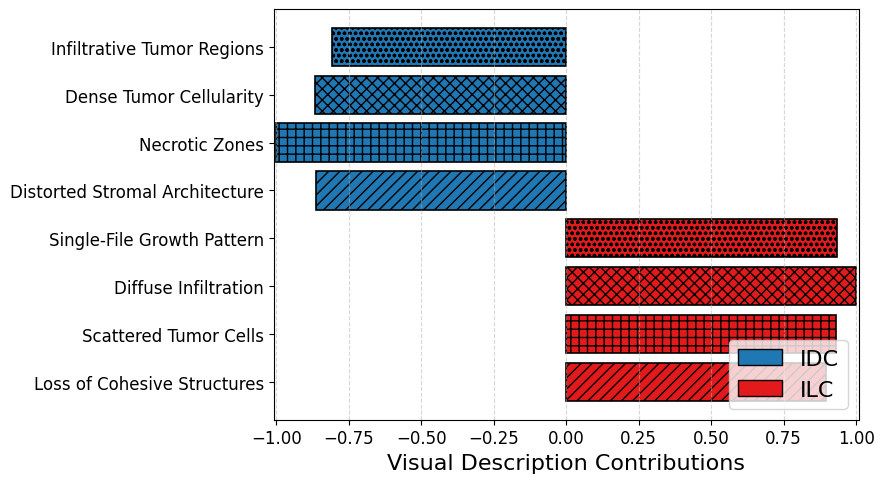

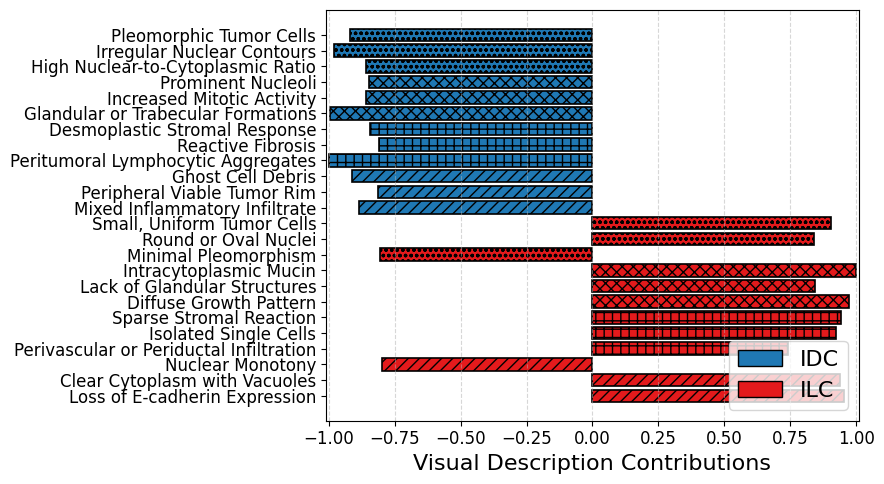

In [ ]:
def plot_similarity(scores, labels, title, colors, hatches):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(9, 5))
    plt.rcParams.update({'font.size': 12, 'font.family': 'DejaVu Sans'})

    labels = labels[::-1]
    scores = scores[::-1]
    colors = colors[::-1]

    bars = plt.barh(labels, scores, color=colors, edgecolor='black', linewidth=1.2)
    for i, bar in enumerate(bars):
        bar.set_hatch(hatches[i % len(hatches)])
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#1F78B4', edgecolor='black', label='IDC'),
        Patch(facecolor='#E31A1C', edgecolor='black', label='ILC')
    ]
    plt.legend(
        handles=legend_elements,
        loc='lower right',
        prop={'size': 16}
    )
    plt.xlim(-1.01, 1.01)
    plt.xlabel("Visual Description Contributions", fontsize=16)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


colors = ['#1F78B4', '#E31A1C']  # IDC: Blue, ILC: Red
hatches = ['///', '++', 'xxx', 'ooo']

with open(args.text_prompt, 'r') as f:
    data = json.load(f)

x5_labels = list(dict(list(data['IDC'].items())[:4]).keys()) + list(dict(list(data['ILC'].items())[:4]).keys())
x5_scores = x5[best_x5_idx].cpu().numpy().tolist() # use the best 5x image index found earlier

x5_colors = [colors[i // 4] for i in range(8)]
plot_similarity(x5_scores, x5_labels, "x5 Image-Text Similarity", x5_colors, hatches)


# ----- x20 -----
x20_labels = list(dict(list(data['IDC'].items())[4:]).keys()) + list(dict(list(data['ILC'].items())[4:]).keys())
x20_scores = x20[best_x20_idx].cpu().numpy().tolist() # use the best 20x image index found earlier
hatches = ['///', '///', '///',
           '++', '++', '++',
           'xxx', 'xxx', 'xxx',
           'ooo', 'ooo', 'ooo'] * 2 

x20_colors = ([colors[0]] * 12 + [colors[1]] * 12)
plot_similarity(x20_scores, x20_labels, "x20 Image-Text Similarity", x20_colors, hatches)
